4 пакетов

доступные поля: ['frame', 'time', 'protocol', 'src_ip', 'dst_ip', 'src_mac', 'dst_mac', 'info', 'eth_dst', 'eth_src']...

DHCP:
  dhcp_type dhcp_hw_type dhcp_hw_len dhcp_hops     dhcp_id dhcp_secs  \
0         1         0x01           6         0  0x00003d1d         0   
1         2         0x01           6         0  0x00003d1d         0   
2         1         0x01           6         0  0x00003d1e         0   
3         2         0x01           6         0  0x00003d1e         0   

  dhcp_flags dhcp_ip_client  dhcp_ip_your dhcp_ip_server dhcp_ip_relay  \
0     0x0000        0.0.0.0       0.0.0.0        0.0.0.0       0.0.0.0   
1     0x0000        0.0.0.0  192.168.0.10    192.168.0.1       0.0.0.0   
2     0x0000        0.0.0.0       0.0.0.0        0.0.0.0       0.0.0.0   
3     0x0000        0.0.0.0  192.168.0.10        0.0.0.0       0.0.0.0   

    dhcp_hw_mac_addr           dhcp_hw_addr_padding dhcp_server dhcp_file  \
0  00:0b:82:01:fc:42  00:00:00:00:00:00:00:00:00:00 

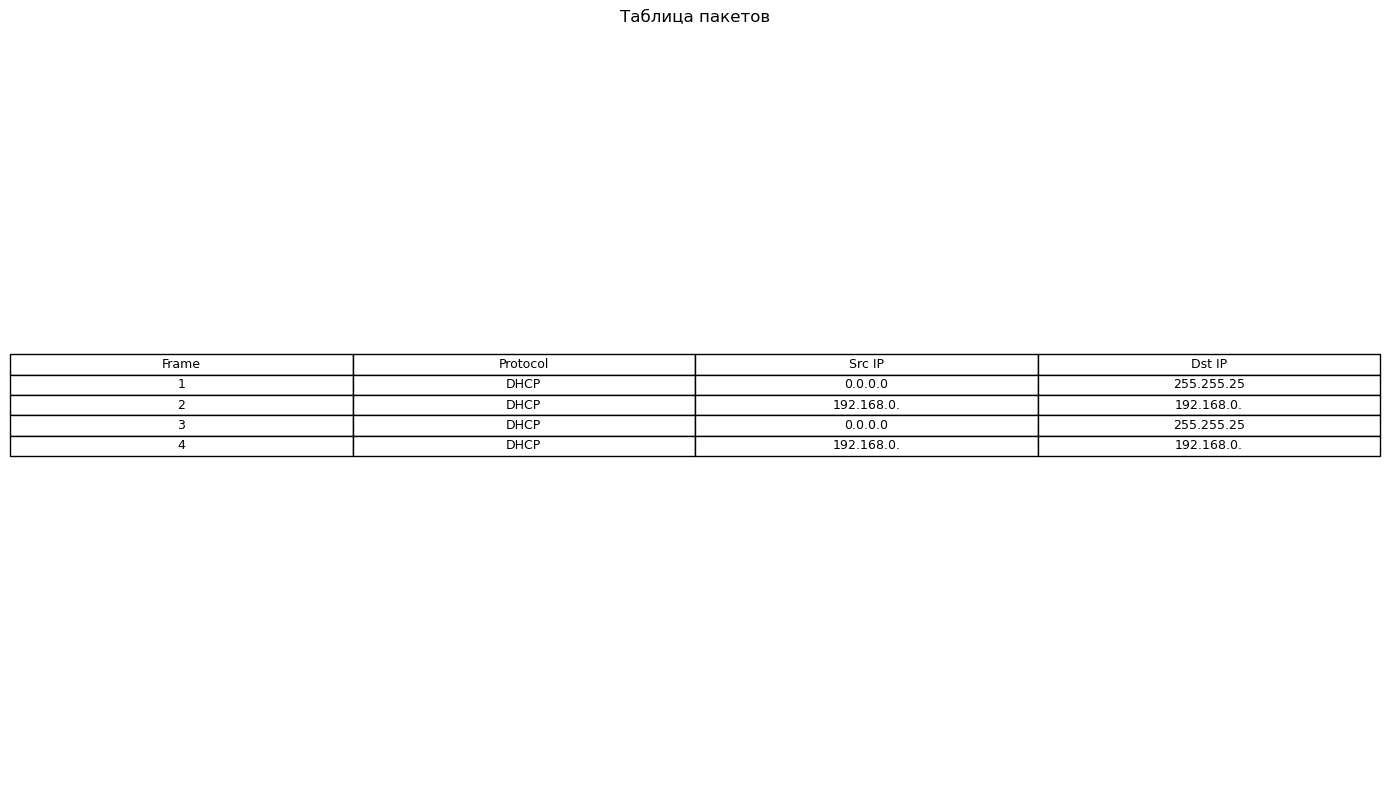

In [5]:
import subprocess
import json
import pandas as pd
import matplotlib.pyplot as plt

TSHARK_PATH = r'C:\Program Files\Wireshark\tshark.exe'
PCAP_FILE = r'C:\Users\Selecty\Documents\python-urfu\lab1\dhcp.pcapng'

print("=" * 100)


cmd = [
    TSHARK_PATH,
    '-r', PCAP_FILE,
    '-T', 'json'           
]

try:
    result = subprocess.run(cmd, capture_output=True, text=True, timeout=30)
    
    if result.returncode == 0:

        data = json.loads(result.stdout)
        
        packets_data = []
        
        for i, packet in enumerate(data):
            try:
                layers = packet['_source']['layers']
                
                packet_info = {
                    'frame': i + 1,
                    'time': layers.get('frame', {}).get('frame.time', ''),
                    'protocol': '',
                    'src_ip': layers.get('ip', {}).get('ip.src', ''),
                    'dst_ip': layers.get('ip', {}).get('ip.dst', ''),
                    'src_mac': layers.get('eth', {}).get('eth.src', ''),
                    'dst_mac': layers.get('eth', {}).get('eth.dst', ''),
                    'info': ''
                }

                for proto in ['dns', 'http', 'dhcp', 'tcp', 'udp']:
                    if proto in layers:

                        packet_info['protocol'] = proto.upper()

                        if proto == 'dhcp':

                            dhcp_type = layers[proto].get('dhcp.option.type', '')
                            packet_info['info'] = f"DHCP type: {dhcp_type}"
                        break
                
                for layer_name in ['eth', 'ip', 'bootp', 'dhcp']:
                    if layer_name in layers:
                        for key, value in layers[layer_name].items():
                            if isinstance(value, str):
                                
                                field_name = key.replace('.', '_').replace('-', '_')
                                packet_info[field_name] = value
                
                packets_data.append(packet_info)

            except Exception as e:
                continue
        
        if packets_data:

            df = pd.DataFrame(packets_data)
            
            print(f"{len(df)} пакетов")

            print(f"\nдоступные поля: {list(df.columns)[:10]}...")
            
            if len(df) > 0:
                
                dhcp_cols = [col for col in df.columns if any(x in col.lower() for x in ['dhcp', 'bootp', 'hostname', 'yiaddr', 'chaddr'])]
                if dhcp_cols:
                    print("\nDHCP:")
                    print(df[dhcp_cols].head())

                    print("\nИнформация о таблице\n")
                    print(df.info())

                    print("\nСтатистика по пакетам\n")
                    print(df.describe())

        else:
            print("ошибка извлечения")
            
    else:
        print(f"ошибка в tshark: {result.stderr[:200]}")
    fig, ax = plt.subplots(figsize=(14, 8))

    ax.axis('tight')
    ax.axis('off')

    table_data = [[row['frame'], row['protocol'], row['src_ip'][:10] if row['src_ip'] else '', 
                   row['dst_ip'][:10] if row['dst_ip'] else ''] for _, row in df.iterrows()]
    if table_data:

        table = ax.table(cellText=table_data, colLabels=['Frame', 'Protocol', 'Src IP', 'Dst IP'], 
                             cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)

    ax.set_title('Таблица пакетов')
    
    plt.tight_layout()
    plt.show()    

except Exception as e:
    print(f"ошибка: {e}")

Я не знаю как еще визуализировать, так что формально нашел что требовалось.